In [3]:
import numpy as np
import pandas as pd
from torch import nn
import torch
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.feature_extraction.text import TfidfVectorizer
from torchtext.vocab import GloVe,vocab
from transformers import (set_seed,
                          AutoTokenizer,
                          AutoModelForQuestionAnswering,
                          TrainingArguments,
                          Trainer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          RobertaTokenizer,
                          RobertaForSequenceClassification,
                          RobertaModel,
                          RobertaConfig,
                          RobertaPreTrainedModel)
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from typing import Optional, Tuple, Union
from transformers.modeling_outputs import SequenceClassifierOutputWithPast

In [4]:
def convert_personality_type_to_binary(mbti_type):
    mapper = {
        'I':0,
        'E':1,
        'N':0,
        'S':1,
        'T':0,
        'F':1,
        'J':0,
        'P':1,
    }

    return [mapper[i] for i in mbti_type]

def convert_personality_type_to_int(mbti_type):
    types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]
    ints = [i for i in range(len(types))]
    mapper = dict(zip(types, ints))

    return mapper[mbti_type]

def convert_binary_to_personality_type(binary_mbti_type):
    mbti_arrays = [['I', 'E'], ['N', 'S'], ['T', 'F'], ['J', 'P']]
    mbti_string = ''
    for idx, mbti_type in enumerate(binary_mbti_type):
        mbti_string += mbti_arrays[idx][int(mbti_type)]
    return mbti_string

In [5]:
class MBTIDataset(Dataset):
    def __init__(self, data_path, vectorizing_method = None, binary_outputs = False, max_seq_len=500):
        """
        Vectorizing methods:
        None - returns raw text
        basic - basic builtin pytorch vectorizer
        TfIdf - tf-idf vectorizer
        GloVe - Global Vectors pretrained embedding
        """
        self.df = pd.read_csv(data_path)
        self.vectorizing_method = vectorizing_method
        self.max_seq_len = max_seq_len
        self.split_dataframe(self.max_seq_len)

        if vectorizing_method:
            if vectorizing_method.lower == 'basic':
                self.tokenizer = get_tokenizer('basic_english')
                self.vocab = build_vocab_from_iterator(self.yield_tokens_from_dataframe(), specials=['<unk>'])
                self.vocab.set_default_index(self.vocab["<unk>"])

            if vectorizing_method.lower == 'tfidf' or vectorizing_method.lower == 'tf-idf':
                self.tokenizer = TfidfVectorizer(stop_words= 'english')
                self.vocab = self.tokenizer.fit_transform(self.df['posts']) # Sparse matrix representation - could use different field names
            if vectorizing_method.lower == 'glove':
                unk_index = 0
                self.global_vectors = GloVe(name='6B', dim=50)
                self.vocab=vocab(self.global_vectors.stoi)
                self.vocab.insert_token("<unk>",unk_index)
                self.vocab.set_default_index(unk_index)

                self.pretrained_embeddings = self.global_vectors.vectors
                self.pretrained_embeddings = torch.cat((torch.zeros(1,self.pretrained_embeddings.shape[1]),self.pretrained_embeddings))


        self.binary_outputs = binary_outputs
        if binary_outputs:
            self.df['type'] = self.df['type'].apply(convert_personality_type_to_binary)
        else:
            self.df['type'] = self.df['type'].apply(convert_personality_type_to_int)

    def yield_tokens_from_dataframe(self):
        for post in self.df['posts']:
            yield self.tokenizer(post)

    def split_dataframe(self, new_seq_len):
        new_df = pd.DataFrame(columns=self.df.columns)
        new_posts = []
        new_types = []
        for idx, row in self.df.iterrows():
            split_posts = row['posts'].split(' ')
            i = 0
            while i < len(split_posts):
                new_posts.append((' ').join(split_posts[i:i+new_seq_len]))
                new_types.append(row['type'])
                i += new_seq_len

        new_df['posts'] = new_posts
        new_df['type'] = new_types
        self.df = new_df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx >= len(self): raise IndexError

        if not self.vectorizing_method :
            return self.df['posts'][idx], self.df['type'][idx]

        input_text = self.vocab(self.df['posts'][idx].split(' '))
        if len(input_text) < self.max_seq_len:
            input_text.extend([0] * (self.max_seq_len-len(input_text)))
        label = self.df['type'][idx]

        return input_text[0:self.max_seq_len], label

In [6]:
class RoBERTaClassificationCollator(object):

    def __init__(self, use_tokenizer, max_sequence_len=None):

        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

    def __call__(self, sequences):

        texts = [sequence[0] for sequence in sequences]
        labels = [sequence[1] for sequence in sequences]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

# Integer outputs

In [7]:
max_seq_len = 500
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
tokenizer.padding_side = "right"
roberta_classificaiton_collator = RoBERTaClassificationCollator(use_tokenizer=tokenizer, max_sequence_len=max_seq_len)

ds = MBTIDataset('../input/mbti-personality-types-500-dataset/MBTI 500.csv', vectorizing_method = None, binary_outputs=False, max_seq_len = max_seq_len)
train_set_size = int(len(ds)*0.7)
val_set_size = int(len(ds)*0.2)
test_set_size = len(ds) - train_set_size - val_set_size
train_ds, val_ds, test_ds = random_split(ds, [train_set_size, val_set_size, test_set_size])

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=roberta_classificaiton_collator)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True, collate_fn=roberta_classificaiton_collator)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=roberta_classificaiton_collator)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels = 16,
    output_attentions = False,
    output_hidden_states = False,
    ignore_mismatched_sizes=True #https://github.com/huggingface/transformers/issues/14218
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,eps = 1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
for epoch in range(epochs):
    model.train()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    
    for batch in tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    

    avg_epoch_loss = total_loss / len(train_dataloader)
    print('Train loss:', avg_epoch_loss)
    
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.eval()

    for batch in tqdm(val_dataloader, total=len(val_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():        
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            predictions_labels += predict_content

    avg_epoch_val_loss = total_loss / len(val_dataloader)
    print('Validation loss:', avg_epoch_val_loss)
    
    torch.save(model.state_dict(), f'./ROBERTA_epoch_{epoch}_val_loss_{avg_epoch_val_loss}.pt')

In [17]:
model.load_state_dict(torch.load(f'../input/075roberta/ROBERTA_epoch_2_val_loss_0.7578748355816717.pt'))
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [18]:
predictions_labels = []
true_labels = []
total_loss = 0
model.eval()

for batch in tqdm(test_dataloader, total=len(test_dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

avg_epoch_loss = total_loss / len(test_dataloader)
print(avg_epoch_loss)

100%|██████████| 1486/1486 [07:49<00:00,  3.17it/s]

0.6163439323519598


In [19]:
print('Accuracy:', accuracy_score(true_labels, predictions_labels))
print('F1 score:', f1_score(true_labels, predictions_labels, average='weighted'))
print('Precision:', precision_score(true_labels, predictions_labels, average='weighted'))
print('Recall:', recall_score(true_labels, predictions_labels, average='weighted'))

Accuracy: 0.799444771599226
F1 score: 0.8000587815528463
Precision: 0.8167615960029074
Recall: 0.799444771599226


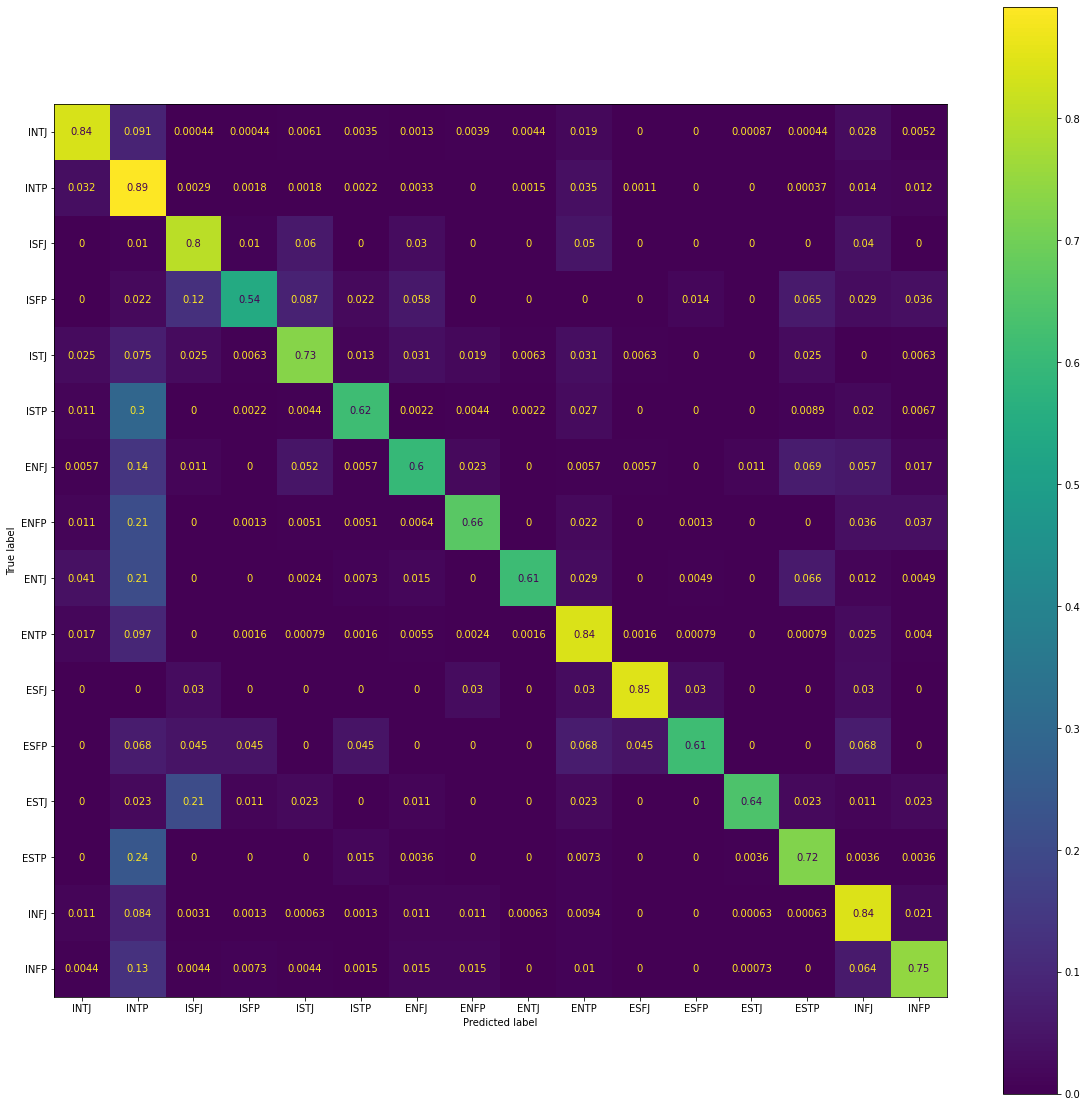

In [20]:
mbti_types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]

fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(true_labels, predictions_labels, labels=[i for i in range(16)], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_types)
disp.plot(ax=ax)

# Binary

In [21]:
class RoBERTaForBinaryMBTIClassification(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.transformer = RobertaModel(config)
        self.EI = nn.Linear(config.hidden_size, 1, bias=False)
        self.NS = nn.Linear(config.hidden_size, 1, bias=False)
        self.TF = nn.Linear(config.hidden_size, 1, bias=False)
        self.JP = nn.Linear(config.hidden_size, 1, bias=False)

        # Model parallel
        self.model_parallel = False
        self.device_map = None

        self.post_init()
        
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutputWithPast]:
        
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.transformer(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = transformer_outputs[0]
        logits = torch.cat((self.EI(hidden_states), self.NS(hidden_states), self.TF(hidden_states), self.JP(hidden_states)), 2)
        if input_ids is not None:
            batch_size, sequence_length = input_ids.shape[:2]
        else:
            batch_size, sequence_length = inputs_embeds.shape[:2]
        
        pooled_logits = logits[torch.arange(batch_size, device=logits.device), -1]
        
        loss = None
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(pooled_logits, labels.float())
            

        if not return_dict:
            output = (pooled_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutputWithPast(
            loss=loss,
            logits=pooled_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )

In [22]:
max_seq_len = 500
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
tokenizer.padding_side = "right"

bert_classificaiton_collator = RoBERTaClassificationCollator(use_tokenizer=tokenizer, max_sequence_len=max_seq_len)


ds = MBTIDataset('../input/mbti-personality-types-500-dataset/MBTI 500.csv', vectorizing_method = None, binary_outputs=True, max_seq_len = max_seq_len)
train_set_size = int(len(ds)*0.7)
val_set_size = int(len(ds)*0.2)
test_set_size = len(ds) - train_set_size - val_set_size
train_ds, val_ds, test_ds = random_split(ds, [train_set_size, val_set_size, test_set_size])

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)

In [23]:
n_labels = 1
model_config = RobertaConfig.from_pretrained(pretrained_model_name_or_path='roberta-base', num_labels=n_labels)

model = RoBERTaForBinaryMBTIClassification.from_pretrained(pretrained_model_name_or_path='roberta-base', config=model_config)
model.config.pad_token_id = model.config.eos_token_id

Some weights of the model checkpoint at roberta-base were not used when initializing RoBERTaForBinaryMBTIClassification: ['roberta.encoder.layer.4.output.dense.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.key.bias', 'roberta.encoder.layer.3.attention.self.value.weight', 'roberta.encoder.layer.11.attention.output.dense.weight', 'roberta.encoder.layer.0.intermediate.dense.bias', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.self.value.bias', 'roberta.encoder.layer.4.intermediate.dense.bias', 'roberta.encoder.layer.3.intermediate.dense.bias', 'roberta.encoder.layer.0.attention.output.dense.weight', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.4.output.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.1.intermediate.dense.we

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [25]:
for epoch in range(epochs):
    model.train()
    
    total_loss = 0
    for batch in tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True):

        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_epoch_loss = total_loss / len(train_dataloader)
    print('Train loss:', avg_epoch_loss)
    
    total_loss = 0
    model.eval()

    for batch in tqdm(val_dataloader, total=len(val_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():        
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()

    avg_epoch_val_loss = total_loss / len(val_dataloader)
    print('Validation loss:', avg_epoch_val_loss)
    
    #Save model and later load the one with the least validation loss
    torch.save(model.state_dict(), f'./ROBERTA_binary_epoch_{epoch}_val_loss_{avg_epoch_val_loss}.pt')

100%|██████████| 10400/10400 [2:29:11<00:00,  1.16it/s] 


Train loss: 0.3931908418911581


100%|██████████| 2972/2972 [15:34<00:00,  3.18it/s]


Validation loss: 0.30202842929900636


100%|██████████| 10400/10400 [2:29:05<00:00,  1.16it/s] 


Train loss: 0.2980048237477716


100%|██████████| 2972/2972 [15:30<00:00,  3.19it/s]


Validation loss: 0.28211822656007085


100%|██████████| 10400/10400 [2:29:06<00:00,  1.16it/s] 


Train loss: 0.2674479378496583


100%|██████████| 2972/2972 [15:33<00:00,  3.19it/s]


Validation loss: 0.28405067105188436


100%|██████████| 10400/10400 [2:29:12<00:00,  1.16it/s] 


Train loss: 0.2403388936290195


100%|██████████| 2972/2972 [15:33<00:00,  3.18it/s]


Validation loss: 0.2803860370343624


In [26]:
model.load_state_dict(torch.load(f'./ROBERTA_binary_epoch_3_val_loss_0.2803860370343624.pt'))
model.eval()

RoBERTaForBinaryMBTIClassification(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [27]:
predictions_labels = []
true_labels = []
total_loss = 0

model.eval()


# Evaluate data for one epoch
for batch in tqdm(test_dataloader, total=len(test_dataloader)):

    true_labels += batch['labels'].numpy().tolist()
    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach()
        total_loss += loss.item()
        predict_content = torch.round(torch.sigmoid(logits)).cpu().numpy().tolist()
        predictions_labels += predict_content

avg_epoch_loss = total_loss / len(test_dataloader)
print(avg_epoch_loss)

100%|██████████| 1486/1486 [07:47<00:00,  3.18it/s]

0.28116560011630826


In [28]:
y_true_array = np.array(true_labels)
y_pred_array = np.array(predictions_labels)

Results of ['I', 'E']:
Accuracy: 0.8799528897114495
F1 score: 0.877102458857789
Precision: 0.8768975417294863
Recall: 0.8799528897114495
Results of ['N', 'S']:
Accuracy: 0.9344662236056196
F1 score: 0.9308880622662192
Precision: 0.9300743364293539
Recall: 0.9344662236056196
Results of ['T', 'F']:
Accuracy: 0.8866829309329519
F1 score: 0.8853829099444289
Precision: 0.8861198597467191
Recall: 0.8866829309329519
Results of ['J', 'P']:
Accuracy: 0.8376377555312526
F1 score: 0.835856493026558
Precision: 0.8379664507298705
Recall: 0.8376377555312526


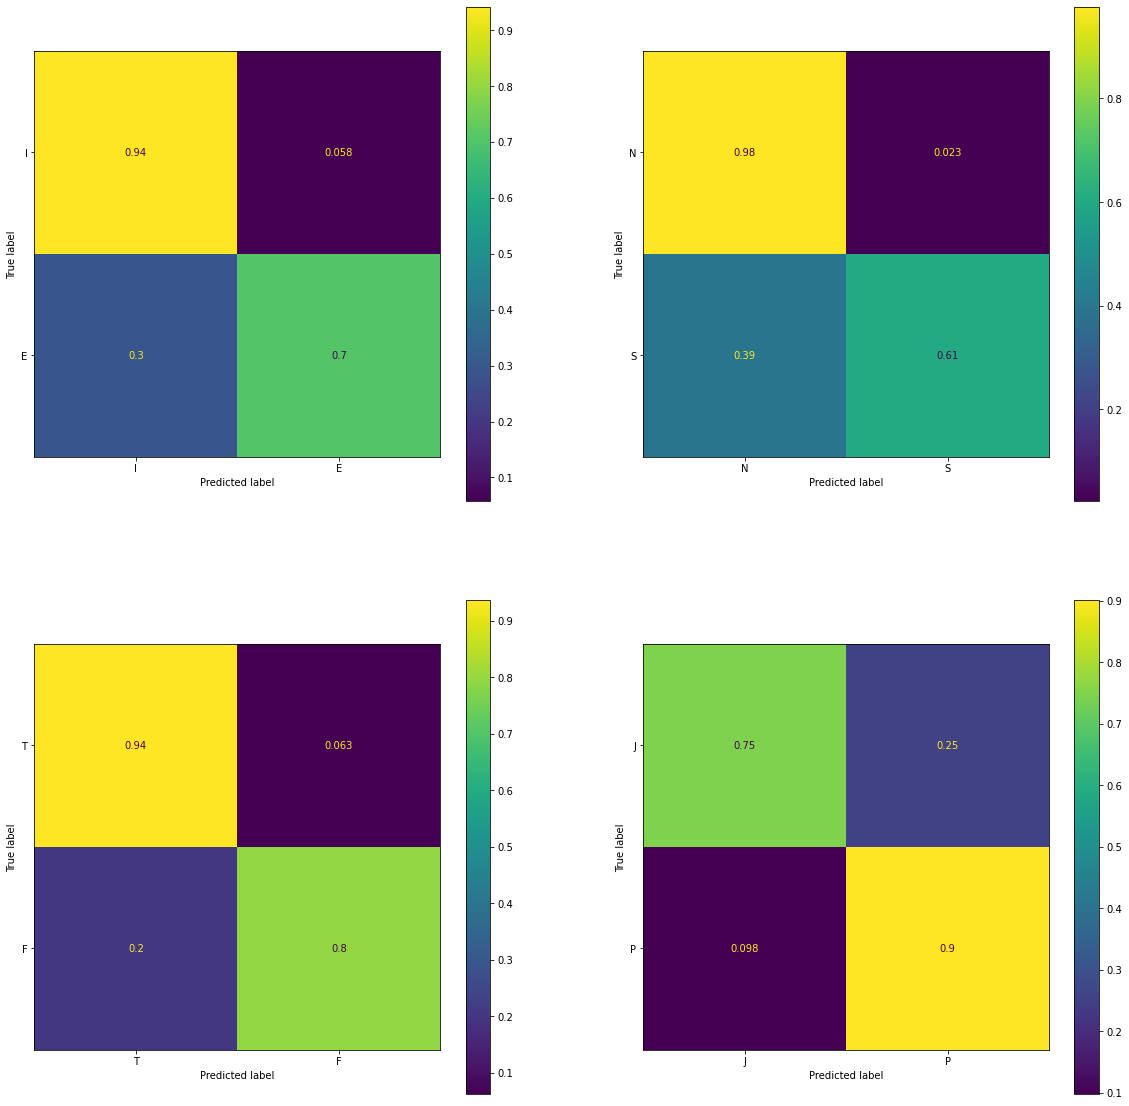

In [29]:
mbti_arrays = [['I', 'E'], ['N', 'S'], ['T', 'F'], ['J', 'P']]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
axes = [ax1, ax2, ax3, ax4]
for i in range(4):
    cm = confusion_matrix(y_true_array[:, i], y_pred_array[:, i], labels=[0, 1], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_arrays[i])
    disp.plot(ax=axes[i])
    
for i in range(4):
    print(f'Results of {mbti_arrays[i]}:')
    print('Accuracy:', accuracy_score(y_true_array[:, i], y_pred_array[:, i]))
    print('F1 score:',f1_score(y_true_array[:, i], y_pred_array[:, i], average='weighted'))
    print('Precision:',precision_score(y_true_array[:, i], y_pred_array[:, i], average='weighted'))
    print('Recall:',recall_score(y_true_array[:, i], y_pred_array[:, i], average='weighted'))

In [30]:
y_true_ints = [convert_personality_type_to_int(convert_binary_to_personality_type(i)) for i in y_true_array]
y_pred_ints = [convert_personality_type_to_int(convert_binary_to_personality_type(i)) for i in y_pred_array]

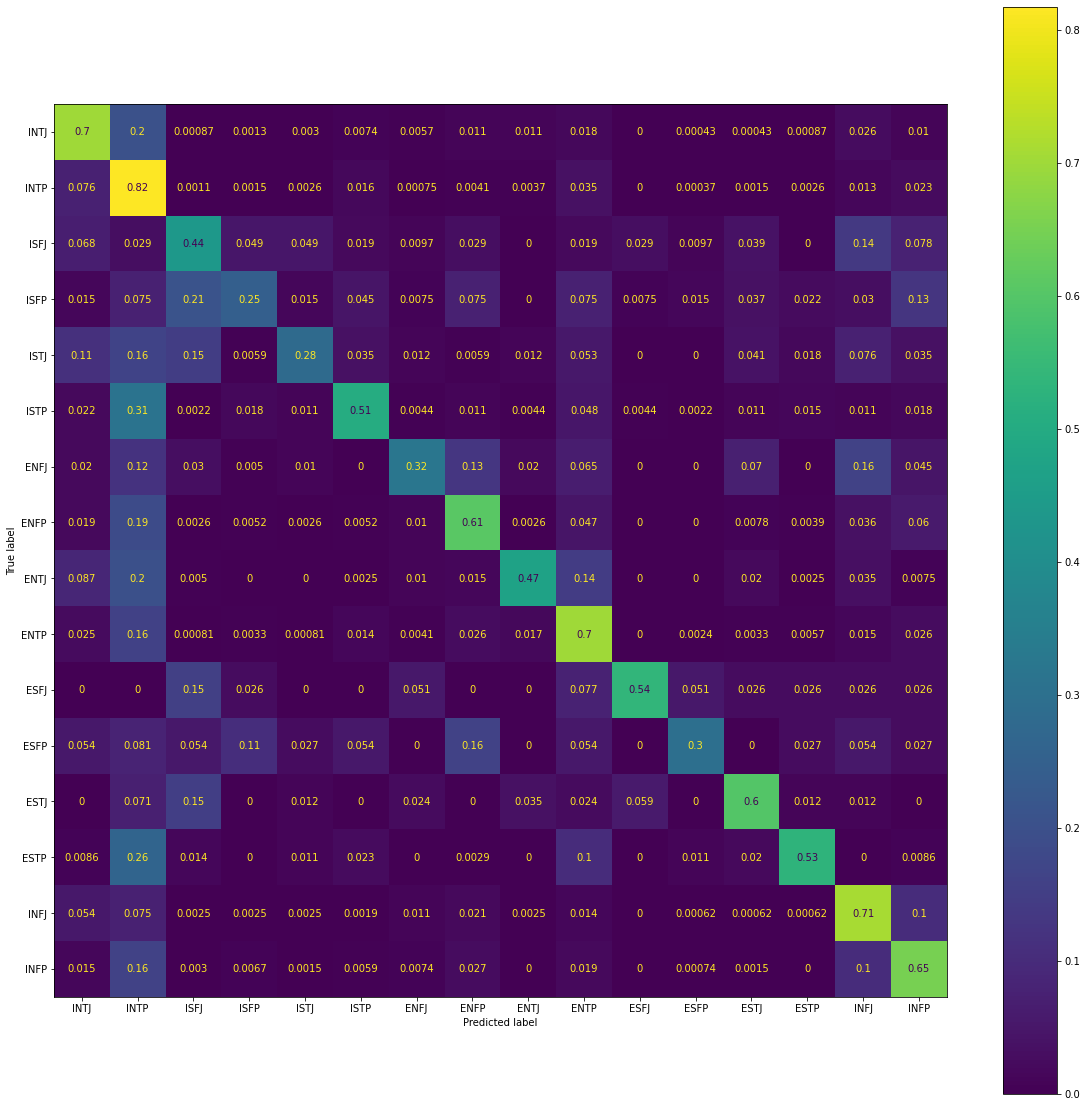

In [31]:
mbti_types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]

fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(y_true_ints, y_pred_ints, labels=[i for i in range(16)], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_types)
disp.plot(ax=ax)

In [32]:
print('Accuracy:', accuracy_score(y_true_ints, y_pred_ints))
print('F1 score:',f1_score(y_true_ints, y_pred_ints, average='weighted'))
print('Precision:',precision_score(y_true_ints, y_pred_ints, average='weighted'))
print('Recall:', recall_score(y_true_ints, y_pred_ints, average='weighted'))

Accuracy: 0.6741818793640111
F1 score: 0.6714729974680437
Precision: 0.6859517654656934
Recall: 0.6741818793640111
